In [ ]:
# Mount on drive if using colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ECE219/Project_1

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1h2lc5bgLi87LcqxNkMp5cx4RJZ_JRvAc/ECE219/Project_1


#Binary Classification

In [ ]:
#Set random seeds for reproducibility
import numpy as np
np.random.seed(42)
import random
random.seed(42)

## Question 1

In [ ]:
import sklearn
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt

In [ ]:
full_dataset = fetch_20newsgroups()

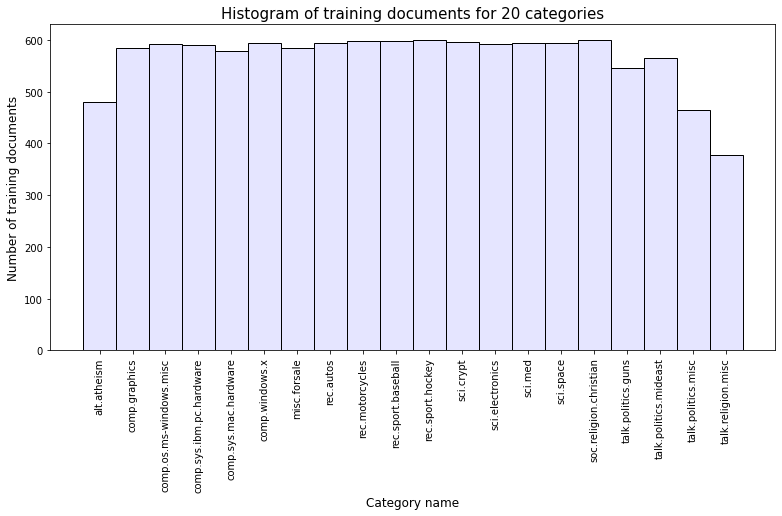

In [ ]:
plt.figure(figsize=(13,6))
ax = plt.subplot(111)
hist = ax.hist(full_dataset.target, bins=range(21), edgecolor='black', facecolor=np.array([0,0,1,0.1]))
plt.xticks([i+0.5 for i in range(20)], full_dataset.target_names, rotation='vertical')
plt.xlabel("Category name", size=12)
plt.ylabel("Number of training documents", size=12)
plt.title("Histogram of training documents for 20 categories", size=15)
plt.show()

In [ ]:
print(hist[0])
print(np.mean(hist[0]))
print(np.std(hist[0]))

[480. 584. 591. 590. 578. 593. 585. 594. 598. 597. 600. 595. 591. 594.
 593. 599. 546. 564. 465. 377.]
565.7
56.776843871423495


##Question 2

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [ ]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = None)

test_dataset  = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = None)

In [ ]:
wnl = WordNetLemmatizer()

train_corpus = []
for file in train_dataset.data:
  tokens = [token for token in nltk.word_tokenize(file) if token.isalpha()]
  pos_tokens = nltk.pos_tag(tokens)
  temp = ""
  for token, pos in pos_tokens:
    lemma = wnl.lemmatize(token, get_wordnet_pos(pos))
    temp += lemma + " "
  train_corpus.append(temp)

test_corpus = []
for file in test_dataset.data:
  tokens = [token for token in nltk.word_tokenize(file) if token.isalpha()]
  pos_tokens = nltk.pos_tag(tokens)
  temp = ""
  for token, pos in pos_tokens:
    lemma = wnl.lemmatize(token, get_wordnet_pos(pos))
    temp += lemma + " "
  test_corpus.append(temp)

KeyboardInterrupt: ignored

In [ ]:
vectorizer = CountVectorizer(stop_words="english", min_df=3)
train_vec = vectorizer.fit_transform(train_corpus)
test_vec = vectorizer.transform(test_corpus)
print(train_vec.shape, test_vec.shape)

(4732, 12601) (3150, 12601)


In [ ]:
transformer = TfidfTransformer()
train_tfifd = transformer.fit_transform(train_vec)
test_tfifd = transformer.transform(test_vec)
print(train_tfifd.shape, test_tfifd.shape)

(4732, 12601) (3150, 12601)


##Question 3

In [ ]:
from sklearn.decomposition import NMF, TruncatedSVD

In [ ]:
NMF_model = NMF(50)
NMF_train = NMF_model.fit_transform(train_tfifd)
NMF_test = NMF_model.transform(test_tfifd)
print("Train reconstruction: %0.2f" % np.linalg.norm(train_tfifd - NMF_train @ NMF_model.components_, "fro"))
print("Test reconstruction: %0.2f" % np.linalg.norm(test_tfifd - NMF_test @ NMF_model.components_, "fro"))

Train reconstruction: 64.45
Test reconstruction: 53.54


In [ ]:
LSI_model = TruncatedSVD(50)
LSI_train = LSI_model.fit_transform(train_tfifd)
LSI_test = LSI_model.transform(test_tfifd)
print("Train reconstruction: %0.2f" % np.linalg.norm(train_tfifd - LSI_train @ LSI_model.components_, "fro"))
print("Test reconstruction: %0.2f" % np.linalg.norm(test_tfifd - LSI_test @ LSI_model.components_, "fro"))

Train reconstruction: 64.19
Test reconstruction: 53.41


In [ ]:
print(NMF_train.shape)
print(NMF_test.shape)
print(LSI_train.shape)
print(LSI_test.shape)

(4732, 50)
(3150, 50)
(4732, 50)
(3150, 50)


##Question 4

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, f1_score, precision_score, plot_confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report


def get_scores(estimator, X, y, title='', labels=['Computer\nTechnology', 'Recreational\nActivity'], binary=True):
  predict = estimator.predict(X)

  # Evaluating the model 
  print(f"Test Set Accuracy : {accuracy_score(y, predict) * 100:{6}.{6}} %\n\n") 
  print(f"Classification Report : \n\n{classification_report(y, predict)}") 

  disp = plot_confusion_matrix(estimator, X, y, 
             cmap = plt.cm.Greys, 
             display_labels = labels, 
             values_format = 'd',
             xticks_rotation='horizontal' if binary else 'vertical')
  disp.ax_.set_title('Confusion Matrix of ' + title)
  plt.ylabel("predicted label")
  plt.show()

  if binary:
    try:
      fpr, tpr, _ = roc_curve(y, estimator.decision_function(X))
    except:
      fpr, tpr, _ = roc_curve(y, estimator.predict_proba(X)[:,1])

    plt.plot(fpr, tpr, color = 'b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of ' + title)
    plt.show()

    return fpr, tpr

In [ ]:
train_labels = []
for label in train_dataset.target:
  new_label = 0 if label < 4 else 1
  train_labels.append(new_label)
  
test_labels = []
for label in test_dataset.target:
  new_label = 0 if label < 4 else 1
  test_labels.append(new_label)

In [ ]:
hard = LinearSVC(C=1000)
hard.fit(LSI_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Test Set Accuracy : 97.5873 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1560
           1       0.97      0.99      0.98      1590

    accuracy                           0.98      3150
   macro avg       0.98      0.98      0.98      3150
weighted avg       0.98      0.98      0.98      3150



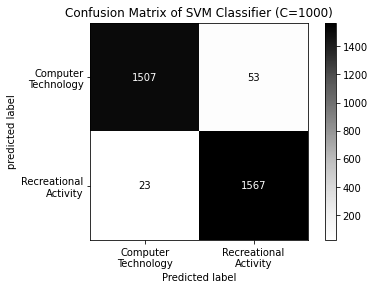

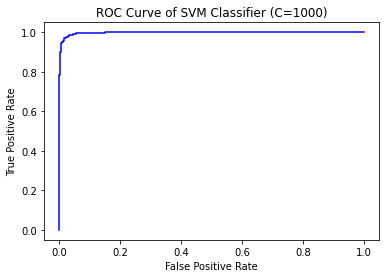

In [ ]:
_ = get_scores(hard, LSI_test, test_labels, 'SVM Classifier (C=1000)')

In [ ]:
soft = LinearSVC(C=1e-4)
soft.fit(LSI_train, train_labels)

LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Test Set Accuracy : 72.9841 %


Classification Report : 

              precision    recall  f1-score   support

           0       1.00      0.45      0.62      1560
           1       0.65      1.00      0.79      1590

    accuracy                           0.73      3150
   macro avg       0.83      0.73      0.71      3150
weighted avg       0.82      0.73      0.71      3150



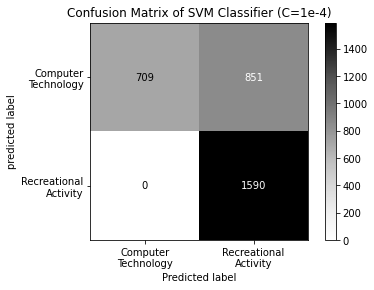

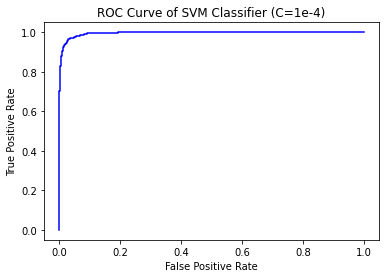

In [ ]:
_ = get_scores(soft, LSI_test, test_labels, 'SVM Classifier (C=1e-4)')

In [ ]:
scores = []
for k in range(-3, 4):
  print(10**k)
  clf = LinearSVC(C=10 ** k)
  scores.append(cross_val_score(clf, LSI_train, train_labels, cv=5))

0.001
0.01
0.1
1
10
100


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

1000


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
avg_scores = [score.mean() for score in scores]
print(avg_scores)
print(np.argmax(np.array(avg_scores)))

[0.9368139289310184, 0.9636517677945934, 0.9706244935045799, 0.975485286796404, 0.9784440014198615, 0.9765414762541551, 0.9668261406332672]
4


In [ ]:
best = LinearSVC(C=10)
best.fit(LSI_train, train_labels)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Test Set Accuracy : 97.6825 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1560
           1       0.97      0.99      0.98      1590

    accuracy                           0.98      3150
   macro avg       0.98      0.98      0.98      3150
weighted avg       0.98      0.98      0.98      3150



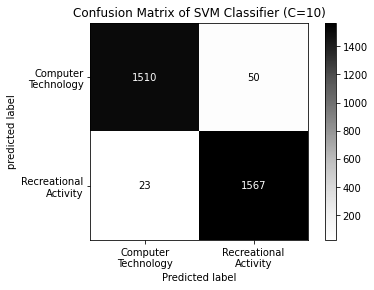

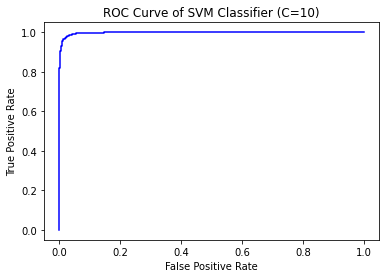

In [ ]:
_ = get_scores(best, LSI_test, test_labels, 'SVM Classifier (C=10)')

## Question 5

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_none = LogisticRegression(penalty = 'none', solver = 'saga')
lr_none.fit(LSI_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Test Set Accuracy : 97.6825 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1560
           1       0.97      0.99      0.98      1590

    accuracy                           0.98      3150
   macro avg       0.98      0.98      0.98      3150
weighted avg       0.98      0.98      0.98      3150



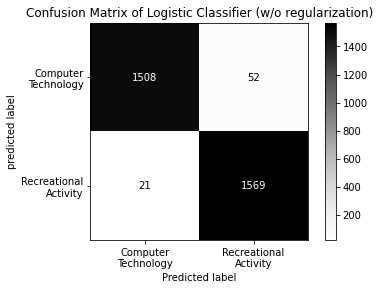

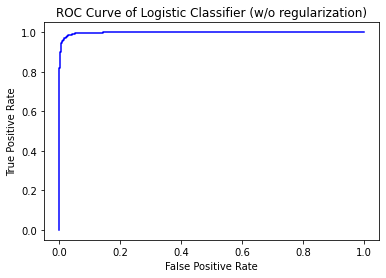

In [ ]:
fpr_none, tpr_none = get_scores(lr_none, LSI_test, test_labels, 'Logistic Classifier (w/o regularization)')

In [ ]:
# 5-fold cross validation and find optimal regularization strength for l1 regularization
scores = []
for k in range(-3, 4):
  clf = LogisticRegression(penalty = 'l1', solver = 'saga', C=10 ** k)
  scores.append(cross_val_score(clf, LSI_train, train_labels, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
avg_scores = [score.mean() for score in scores]
print(avg_scores)
print(np.argmax(np.array(avg_scores)))

[0.5012684989429175, 0.9361790097135497, 0.9497045303852604, 0.9714706059638651, 0.9782321384320353, 0.9771757257256141, 0.9769643092351277]
4


In [ ]:
lr_l1_best = LogisticRegression(penalty = 'l1', solver = 'saga', C=1000)
lr_l1_best.fit(LSI_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Test Set Accuracy : 97.6825 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1560
           1       0.97      0.99      0.98      1590

    accuracy                           0.98      3150
   macro avg       0.98      0.98      0.98      3150
weighted avg       0.98      0.98      0.98      3150



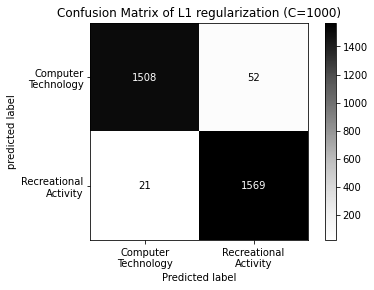

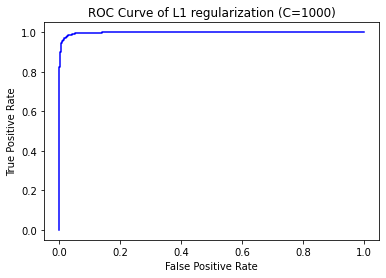

In [ ]:
fpr_l1, tpr_l1 = get_scores(lr_l1_best, LSI_test, test_labels, 'L1 regularization (C=1000)')

In [ ]:
# 5-fold cross validation and find optimal regularization strength for l2 regularization
scores = []
for k in range(-3, 4):
  clf = LogisticRegression(penalty = 'l2', solver = 'saga', C=10 ** k)
  scores.append(cross_val_score(clf, LSI_train, train_labels, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
avg_scores = [score.mean() for score in scores]
print(avg_scores)
print(np.argmax(np.array(avg_scores)))

[0.5426878246872844, 0.9378707881347796, 0.9644967640105284, 0.9710475497342224, 0.9752734238085777, 0.9780213916875591, 0.977175948974284]
5


In [ ]:
lr_l2_best = LogisticRegression(penalty = 'l2', solver = 'saga', C=1000)
lr_l2_best.fit(LSI_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Test Set Accuracy : 97.6508 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1560
           1       0.97      0.99      0.98      1590

    accuracy                           0.98      3150
   macro avg       0.98      0.98      0.98      3150
weighted avg       0.98      0.98      0.98      3150



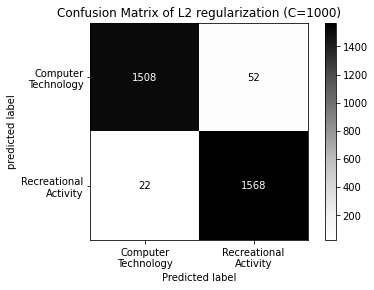

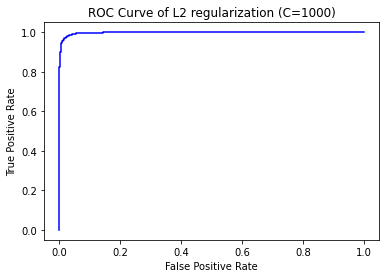

In [ ]:
fpr_l2, tpr_l2 = get_scores(lr_l2_best, LSI_test, test_labels, 'L2 regularization (C=1000)')

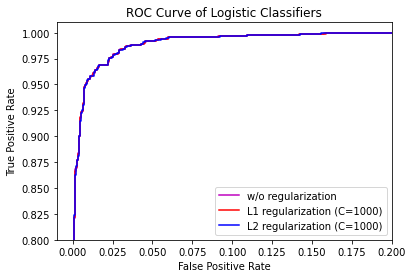

In [ ]:
plt.plot(fpr_none, tpr_none, label = 'w/o regularization', color = 'm')
plt.plot(fpr_l1, tpr_l1, label = 'L1 regularization (C=1000)', color = 'r')
plt.plot(fpr_l2, tpr_l2, label = 'L2 regularization (C=1000)', color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim(-0.01, 0.2)
plt.ylim(0.8, 1.01)
plt.title('ROC Curve of Logistic Classifiers')
plt.show()

##Question 6

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
naiveB = GaussianNB()
naiveB.fit(LSI_train, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

Test Set Accuracy : 84.5397 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1560
           1       0.78      0.97      0.86      1590

    accuracy                           0.85      3150
   macro avg       0.87      0.84      0.84      3150
weighted avg       0.87      0.85      0.84      3150



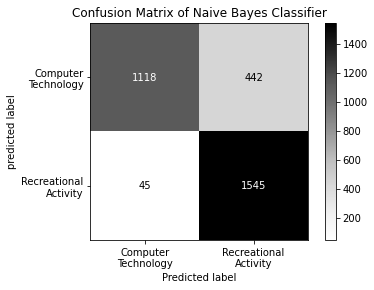

NB


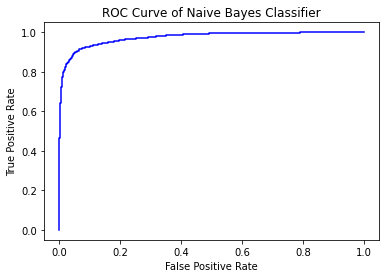

In [ ]:
_ = get_scores(naiveB, LSI_test, test_labels, 'Naive Bayes Classifier')

## Question 7

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pandas as pd

In [ ]:
pipeline = Pipeline([
  ('vectorizer', CountVectorizer(stop_words='english')), 
  ('tfidf', TfidfTransformer()), 
  ('reduce_dim', TruncatedSVD()), 
  ('classifier', LinearSVC()),
])

options = [{
  'vectorizer__min_df': [3, 5], 
  'reduce_dim': [TruncatedSVD(n_components=50, random_state=42), 
          NMF(n_components=50, random_state=42)], 
  'classifier': [LinearSVC(C=1), 
          LogisticRegression(penalty='l1', C=1000, solver='saga', random_state=42), 
          LogisticRegression(penalty='l2', C=1000, solver='saga', random_state=42), 
          GaussianNB()]
}]

In [ ]:
# With headers and footers
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=options, scoring='accuracy')
grid1.fit(train_corpus, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [ ]:
pd.DataFrame(grid1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_reduce_dim,param_vectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.517808,0.022408,0.203416,0.003367,"LinearSVC(C=1, class_weight=None, dual=True, f...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.975713,0.976769,0.969345,0.973573,0.978858,0.974851,0.003238,6
1,1.386481,0.037544,0.206443,0.009899,"LinearSVC(C=1, class_weight=None, dual=True, f...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.972545,0.977825,0.970402,0.974630,0.978858,0.974852,0.003164,5
2,24.355034,3.324460,0.297579,0.015073,"LinearSVC(C=1, class_weight=None, dual=True, f...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.958817,0.963041,0.967230,0.968288,0.968288,0.965133,0.003703,12
3,19.990073,2.342167,0.282335,0.013592,"LinearSVC(C=1, class_weight=None, dual=True, f...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.956705,0.970433,0.964059,0.967230,0.974630,0.966612,0.006065,11
4,2.009286,0.024884,0.202397,0.001801,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.976769,0.980993,0.974630,0.972516,0.979915,0.976965,0.003169,1
5,1.932962,0.039069,0.200238,0.005683,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.974657,0.977825,0.973573,0.973573,0.983087,0.976543,0.003624,3
6,25.042105,3.436940,0.296529,0.007162,"LogisticRegression(C=1000, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.964097,0.971489,0.971459,0.973573,0.976744,0.971472,0.004162,9
7,20.362917,2.270897,0.277384,0.010398,"LogisticRegression(C=1000, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.967265,0.975713,0.971459,0.971459,0.977801,0.972739,0.003680,7
8,1.843320,0.045820,0.203482,0.008812,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.975713,0.980993,0.974630,0.972516,0.979915,0.976753,0.003210,2
9,1.738911,0.033442,0.196284,0.004810,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.974657,0.977825,0.972516,0.974630,0.983087,0.976543,0.003685,3


In [ ]:
grid1.best_params_

{'classifier': LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=42, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
              tol=0.0),
 'vectorizer__min_df': 3}

Test Set Accuracy : 97.4921 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1560
           1       0.97      0.98      0.98      1590

    accuracy                           0.97      3150
   macro avg       0.98      0.97      0.97      3150
weighted avg       0.98      0.97      0.97      3150



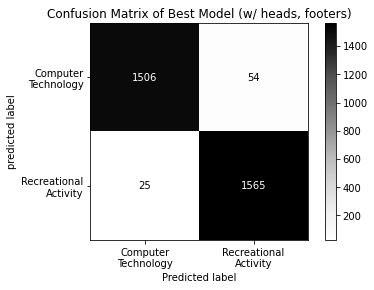

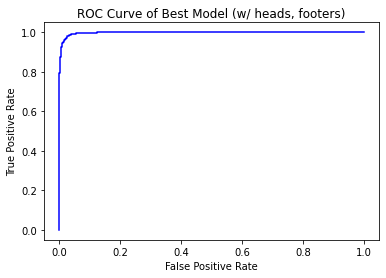

In [ ]:
best_model1 = grid1.best_estimator_
_ = get_scores(best_model1, test_corpus, test_labels, 'Best Model (w/ heads, footers)')

In [ ]:
# Without headers and footers 
train_dataset_no_hf = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None, remove=('headers', 'footers'))
test_dataset_no_hf = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None, remove=('headers', 'footers'))

In [ ]:
train_labels_no_hf = []
for label in train_dataset_no_hf.target:
  new_label = 0 if label < 4 else 1
  train_labels_no_hf.append(new_label)
  
test_labels_no_hf = []
for label in test_dataset_no_hf.target:
  new_label = 0 if label < 4 else 1
  test_labels_no_hf.append(new_label)

In [ ]:
def lemmatize(dataset):
  wnl = WordNetLemmatizer()

  data_corpus = []
  for file in dataset.data:
    tokens = [token for token in nltk.word_tokenize(file) if token.isalpha()]
    pos_tokens = nltk.pos_tag(tokens)
    temp = ""
    for token, pos in pos_tokens:
      lemma = wnl.lemmatize(token, get_wordnet_pos(pos))
      temp += lemma + " "
    data_corpus.append(temp)
  return data_corpus

In [ ]:
train_corpus_no_hf = lemmatize(train_dataset_no_hf)
grid2 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=options, scoring='accuracy')
grid2.fit(train_corpus_no_hf, train_labels_no_hf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [ ]:
pd.DataFrame(grid2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_reduce_dim,param_vectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.237111,0.018024,0.174679,0.011417,"LinearSVC(C=1, class_weight=None, dual=True, f...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.951426,0.957761,0.967230,0.966173,0.961945,0.960907,0.005807,6
1,1.153840,0.014148,0.176876,0.021389,"LinearSVC(C=1, class_weight=None, dual=True, f...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.954593,0.957761,0.966173,0.967230,0.960888,0.961329,0.004829,5
2,16.199812,1.642890,0.237470,0.011389,"LinearSVC(C=1, class_weight=None, dual=True, f...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.931362,0.945090,0.954545,0.945032,0.945032,0.944212,0.007403,12
3,16.089192,2.753570,0.221413,0.008500,"LinearSVC(C=1, class_weight=None, dual=True, f...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'classifier': LinearSVC(C=1, class_weight=Non...",0.935586,0.938754,0.960888,0.943975,0.942918,0.944424,0.008761,11
4,1.731489,0.038050,0.158141,0.011539,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.960929,0.963041,0.971459,0.970402,0.959831,0.965132,0.004857,1
5,1.698843,0.026999,0.165448,0.007217,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.958817,0.961985,0.970402,0.967230,0.956660,0.963019,0.005126,4
6,16.764563,1.641653,0.232381,0.004680,"LogisticRegression(C=1000, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.948258,0.951426,0.967230,0.966173,0.949260,0.956469,0.008424,8
7,16.721548,2.795681,0.221034,0.011245,"LogisticRegression(C=1000, class_weight=None, ...","NMF(alpha=0.0, beta_loss='frobenius', init=Non...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.944034,0.954593,0.966173,0.964059,0.952431,0.956258,0.008075,9
8,1.561040,0.032436,0.159703,0.011287,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",3,"{'classifier': LogisticRegression(C=1000, clas...",0.959873,0.961985,0.971459,0.971459,0.959831,0.964921,0.005394,2
9,1.514476,0.041232,0.162564,0.004190,"LogisticRegression(C=1000, class_weight=None, ...","TruncatedSVD(algorithm='randomized', n_compone...",5,"{'classifier': LogisticRegression(C=1000, clas...",0.959873,0.961985,0.970402,0.967230,0.956660,0.963230,0.004968,3


In [ ]:
grid2.best_params_

{'classifier': LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=42, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
              tol=0.0),
 'vectorizer__min_df': 3}

Test Set Accuracy : 96.7619 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1560
           1       0.97      0.97      0.97      1590

    accuracy                           0.97      3150
   macro avg       0.97      0.97      0.97      3150
weighted avg       0.97      0.97      0.97      3150



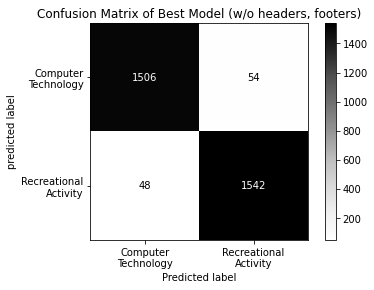

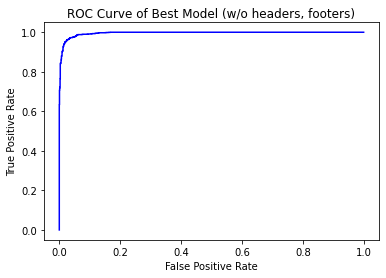

In [ ]:
best_model2 = grid2.best_estimator_
test_corpus_no_hf = lemmatize(test_dataset_no_hf)
_ = get_scores(best_model2, test_corpus_no_hf, test_labels_no_hf, 'Best Model (w/o headers, footers)')

#Word Embedding

##Question 8

In [ ]:
# Download and unip GLoVE embeddings
!wget nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
from numpy import linalg as LA

In [ ]:
embeddings_dict_300 = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32") 
    embeddings_dict_300[word] = vector

In [ ]:
C = LA.norm(embeddings_dict_300['queen'] - embeddings_dict_300['king'] - embeddings_dict_300['wife'] + embeddings_dict_300['husband'])
print(LA.norm(C))

6.1650367


In [ ]:
A = LA.norm(embeddings_dict_300['queen'] - embeddings_dict_300['king'])
B = LA.norm(embeddings_dict_300['wife'] - embeddings_dict_300['husband'])
print(A)
print(B)

5.966258
3.1520464


## Question 9

### (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document.

1) Preprocessing data : tokenize and lemmatize each document in the text.

2) Prepare GLoVE embeddings dictionary : load in the GloVe embedding and appending them to a dictionary.

3) Obtain GLoVE embeddings matrix : creating an embedding matrix for each word in each document in the training set. Obtain the embedding vector for each word from the embedding dictionary. For words not found in the embedding dictionary, we will have a matrix representation with all zeros. 

4) Aggregate these words into a single vector: Use the column mean of the embedding matrix to obtain a vector to represent each document.


### (b) Select a classifier model, train and evaluate it with your GLoVE-based feature.

In [ ]:
class W2vVectorizer(object):
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])

    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
train_data=[nltk.word_tokenize(text.lower()) for text in train_corpus]
test_data=[nltk.word_tokenize(text.lower()) for text in test_corpus]

In [ ]:
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict_300)),
                ('Support Vector Machine', LinearSVC())])
svc.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x7fd535e28978>),
                ('Support Vector Machine',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

Test Set Accuracy : 97.1746 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1560
           1       0.97      0.98      0.97      1590

    accuracy                           0.97      3150
   macro avg       0.97      0.97      0.97      3150
weighted avg       0.97      0.97      0.97      3150



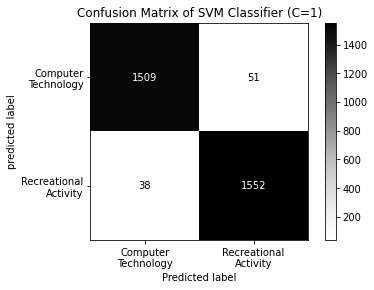

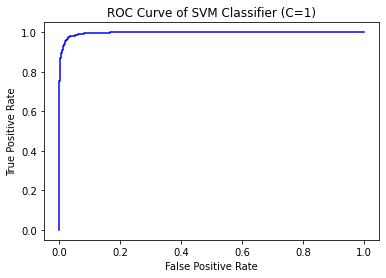

In [ ]:
_ = get_scores(svc, test_data, test_labels, 'SVM Classifier (C=1)')

##Question 10

In [ ]:
embeddings_dict_50 = {}
dimension_of_glove = 50
with open("glove.6B.50d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32") 
    embeddings_dict_50[word] = vector

embeddings_dict_100 = {}
dimension_of_glove = 100
with open("glove.6B.100d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32") 
    embeddings_dict_100[word] = vector

embeddings_dict_200 = {}
dimension_of_glove = 200
with open("glove.6B.200d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32") 
    embeddings_dict_200[word] = vector

In [ ]:
svcs = [Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict_50)),
                ('Support Vector Machine', LinearSVC())]),
        Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict_100)),
                ('Support Vector Machine', LinearSVC())]),
        Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict_200)),
                ('Support Vector Machine', LinearSVC())]),
        Pipeline([('Word2Vec Vectorizer', W2vVectorizer(embeddings_dict_300)),
                ('Support Vector Machine', LinearSVC())])]

In [ ]:
svc_train_accs = []
svc_test_accs = []
for svc in svcs:
  clf = svc.fit(train_data, train_labels)
  svc_train_accs.append(clf.score(train_data, train_labels))
  svc_test_accs.append(clf.score(test_data, test_labels))

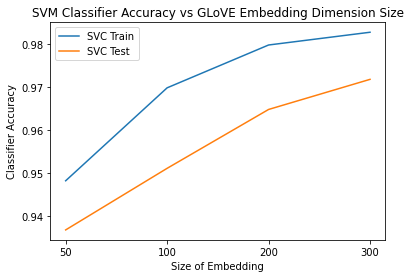

In [ ]:
plt.plot(range(4), svc_train_accs)
plt.plot(range(4), svc_test_accs)
plt.legend(["SVC Train", "SVC Test", "LR Train", "LR Test"])
plt.xticks(range(4), ["50", "100", "200", "300"])
plt.xlabel("Size of Embedding")
plt.ylabel("Classifier Accuracy")
plt.title("SVM Classifier Accuracy vs GLoVE Embedding Dimension Size")
plt.show()

##Question 11

In [ ]:
# Install and import umap
!pip install umap-learn
!pip install umap-learn[plot]

     |████████████████████████████████| 1.6MB 8.1MB/s 
     |████████████████████████████████| 15.8MB 337kB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 675kB 47.5MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=601e3db06ed69ca3f20c251b4afc5c4e8d50d9d00dc9492ac08756afc946e651
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=0a74ecbb627f555ce957feb713d8c84224476e9877a9481fbc01cd6516be063d
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built datashape contextvars
ERROR: distributed 2021.1.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.

In [ ]:
import umap
import umap.plot

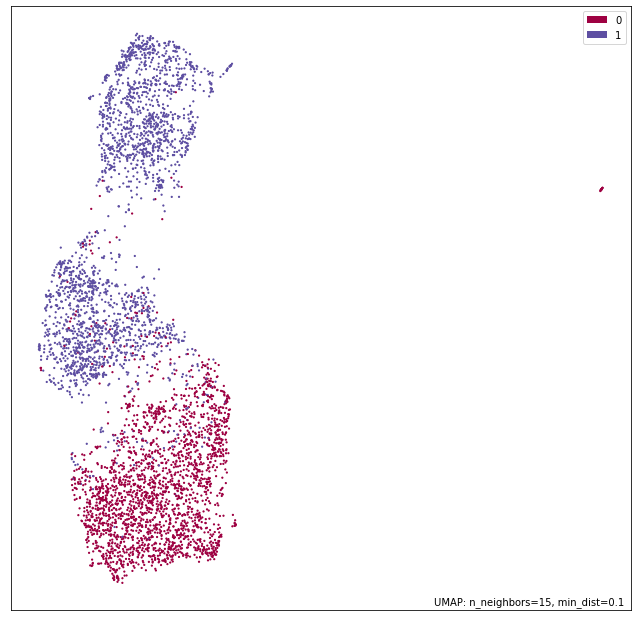

In [ ]:
w2v_300 = W2vVectorizer(embeddings_dict_300)
w2v_data_300 = w2v_300.transform(train_data)
embeddings_300 = umap.UMAP(n_components=2).fit(w2v_data_300)
f = umap.plot.points(embeddings_300, labels=np.array(train_labels))

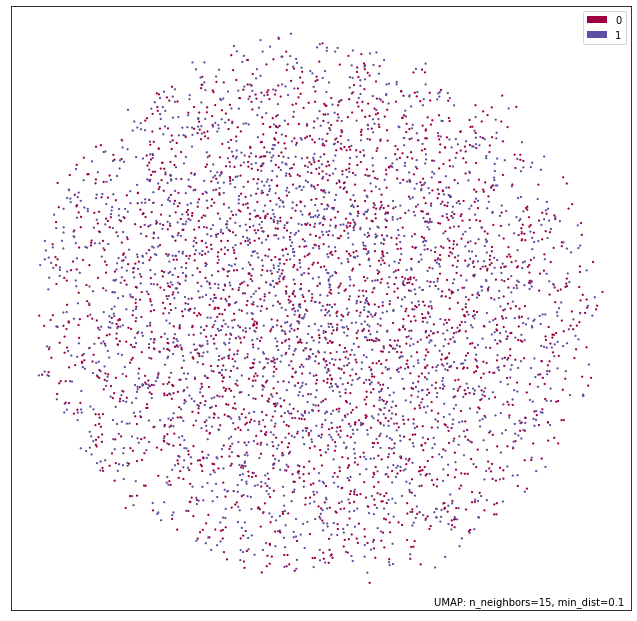

In [ ]:
r = np.random.rand(*w2v_data_300.shape)
r_norm = r/np.linalg.norm(r)
r_embeddings = umap.UMAP(n_components=2).fit(r_norm)
f = umap.plot.points(r_embeddings, labels=np.array(train_labels))

## Multiclass Classification

### QUESTION 12

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [ ]:
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','misc.forsale', 'soc.religion.christian']
multi_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                 )
multi_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [ ]:
wnl = WordNetLemmatizer()

train_corpus_multi = []
for file in multi_train.data:
    tokens = [token for token in nltk.word_tokenize(file) if token.isalpha()]
    pos_tokens = nltk.pos_tag(tokens)
    temp = ""
    for token, pos in pos_tokens:
        lemma = wnl.lemmatize(token, get_wordnet_pos(pos))
        temp += lemma + " "
    train_corpus_multi.append(temp)

test_corpus_multi = []
for file in multi_test.data:
    tokens = [token for token in nltk.word_tokenize(file) if token.isalpha()]
    pos_tokens = nltk.pos_tag(tokens)
    temp = ""
    for token, pos in pos_tokens:
        lemma = wnl.lemmatize(token, get_wordnet_pos(pos))
        temp += lemma + " "
    test_corpus_multi.append(temp)

### Naive Bayes classification

In [ ]:
nb_multinomial = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, init='random', random_state=0)),
    ('clf', MultinomialNB()),
])
nb_multinomial.fit(train_corpus_multi, multi_train.target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('reduce_dim',
                 NMF(alpha=0.0, beta_loss='frobenius', init='random',
                     l1_ratio=0.0, max_iter=200, n_components=50,
     

Test Set Accuracy : 80.7668 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       392
           1       0.86      0.63      0.73       385
           2       0.76      0.81      0.78       390
           3       0.97      0.98      0.98       398

    accuracy                           0.81      1565
   macro avg       0.82      0.81      0.81      1565
weighted avg       0.82      0.81      0.81      1565



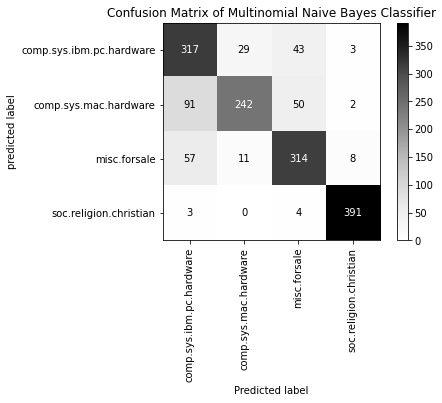

In [ ]:
_ = get_scores(nb_multinomial, test_corpus_multi, multi_test.target, 'Multinomial Naive Bayes Classifier', labels=multi_test.target_names, binary=False)

### SVM classification (One VS One)

In [ ]:
svm_1v1 = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', OneVsOneClassifier(LinearSVC(random_state=42)) ),
    ])
svm_1v1.fit(train_corpus_multi, multi_train.target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                ('reduce_dim',
                 TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
                              random_state=0, tol=0.0)),
                ('clf',
                 OneVsOneClassifier(estimator=LinearSVC(C=1.0,
                                                        class_weight=None,
     

Test Set Accuracy : 88.3067 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       392
           1       0.86      0.81      0.83       385
           2       0.90      0.89      0.90       390
           3       0.99      0.97      0.98       398

    accuracy                           0.88      1565
   macro avg       0.89      0.88      0.88      1565
weighted avg       0.89      0.88      0.88      1565



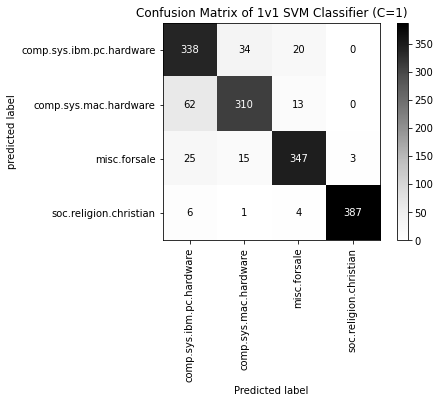

In [ ]:
_ = get_scores(svm_1v1, test_corpus_multi, multi_test.target, '1v1 SVM Classifier (C=1)', labels=multi_test.target_names, binary=False)

### SVM classification (One VS Rest)

In [ ]:
svm_1vrest = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', OneVsRestClassifier(LinearSVC(random_state=42))),
     ])
svm_1vrest.fit(train_corpus_multi, multi_train.target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                ('reduce_dim',
                 TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
                              random_state=0, tol=0.0)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
   

Test Set Accuracy : 88.5623 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       392
           1       0.85      0.81      0.83       385
           2       0.91      0.90      0.91       390
           3       0.97      0.98      0.98       398

    accuracy                           0.89      1565
   macro avg       0.89      0.88      0.88      1565
weighted avg       0.89      0.89      0.89      1565



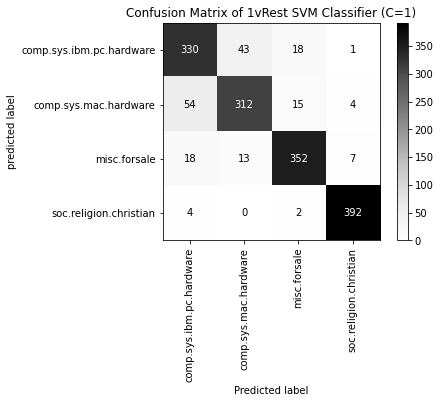

In [ ]:
_ = get_scores(svm_1vrest, test_corpus_multi, multi_test.target, '1vRest SVM Classifier (C=1)', labels=multi_test.target_names, binary=False)